In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sepia.SepiaModelSetup import setup_model
from sepia.SepiaData import SepiaData
from sepia.SepiaPredict import SepiaXvalEmulatorPrediction, SepiaEmulatorPrediction, SepiaFullPrediction

## Univariate-output simple example

### Create synthetic data

In this example, we use synthetic data generated as follows.

Simulation data: $y_{sim} = 2.5 \cos(10 t)$

Observed data: $y_{obs} = 2.5 \cos(10 t) + \epsilon$

where $\epsilon \sim N(0, \sigma^2_n)$.

In this case, $t$ is a univariate input variable.

In the model, the simulation data output $y$ is assumed to vary smoothly with $t$.
The observed data output is assumed to conform to the same relationship (plus white noise),
but the true input value generating $y_{obs}$ would not be known in advance.
That is, in this example, we generate the $t$ corresponding to $y_{obs}$, but in a real data situation,
this would be unknown.
We conventionally use $\theta$ to refer to the unknown input value that would generate the observed data.

The goal of emulation and calibration is to:

1. Based on the simulation data, capture the smooth relationship between $t$ and $y$ with a Gaussian process.
2. Infer the posterior distribution over $\theta$ corresponding to the observed data.

First, we generate the synthetic data.

In [2]:
seed = 42   # random seed
m = 100     # number of simulated data observations
n = 1       # number of observed data observations
sig_n = 0.1 # observation noise SD

np.random.seed(seed)

# Sim data
t_sim = np.linspace(0, 10, m)[:, None]
y_sim = 2.5 * np.cos(t_sim)

# Obs data
t_obs = np.array([[7.5]])
y_obs = 2.5 * np.cos(t_obs) + sig_n * np.random.normal(size=(n, 1))

### Create SepiaData object

Next, we initialize the SepiaData object which does some basic checking about whether the input data
are of the correct shapes, and infers what kind of model you're going to use based on the input data.
In this case, we pass in $t_{sim}$, $y_{sim}$, and $y_{obs}$ to indicate that we have both simulated
and observed data.

In [3]:
data = SepiaData(t_sim=t_sim, y_sim=y_sim, y_obs=y_obs)
print(data)

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 1, obs y dimension 1
n  =     1 (number of observed data)
m  =   100 (number of simulated data)
p  =     1 (number of inputs)
q  =     1 (number of additional simulation inputs to calibrate)
pu =     1 (univariate response dimension)


This is what the data looks like: in the simulations (black dots), $y$ varies smoothly with $t$.
The observed data $y$ is shown as a horizontal line.
Based on the $y$/$t$ relationship apparent in the simulations,
there are three regions where $t$ would produce values consistent with the observed $y$.
Not only will the true generating input value of 7.5 (grey dashed line) match $y_{obs}$,
but so will $t \approx 1.5$ and $t \approx 5$.

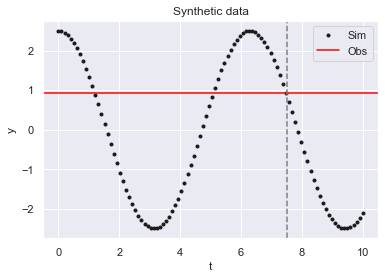

In [4]:
plt.plot(data.sim_data.t, data.sim_data.y, 'k.')
plt.axhline(data.obs_data.y, color='red')
plt.axvline(t_obs, color='grey', linestyle='dashed')
plt.title('Synthetic data')
plt.xlabel('t')
plt.ylabel('y')
plt.legend(['Sim', 'Obs'])
plt.show()

Standardization of data is important for default priors in the model to work well.

We transform $t$ to lie in [0, 1] and standardize the $y$ values:

In [5]:
data.transform_xt()
data.standardize_y()

### Create SepiaModel using setup_model

Next, we set up the model object; a lot of precalculation of important model components is done here.

In [6]:
model = setup_model(data)

### Do MCMC

We will use all the default priors and settings to do MCMC.

We first call `model.tune_step_sizes(50, 20)` which uses 50 samples over 20 different step sizes
to find one with a good acceptance rate.

We then draw 1000 MCMC samples.

In [7]:
model.tune_step_sizes(50, 20)
model.do_mcmc(1000)

MCMC sampling: 100%|██████████| 1000/1000 [00:04<00:00, 239.38it/s]


tuning step sizes...
done with step size selection


Here is a basic visualization of the MCMC results: histograms of the MCMC samples.
Notice the argument `untransform_theta` puts theta samples back on the original scale.

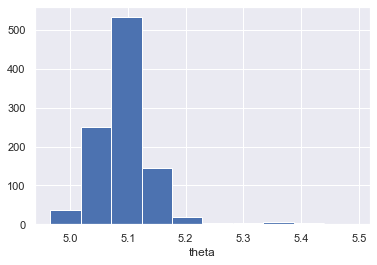

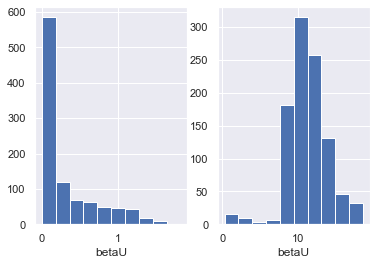

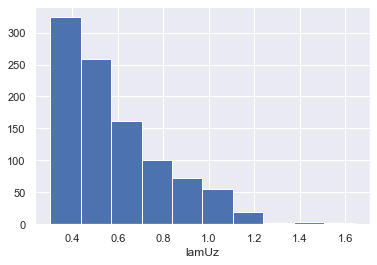

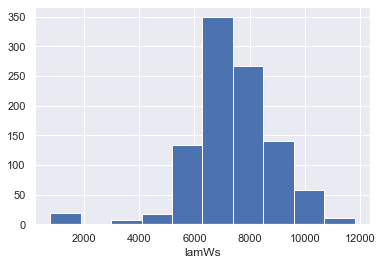

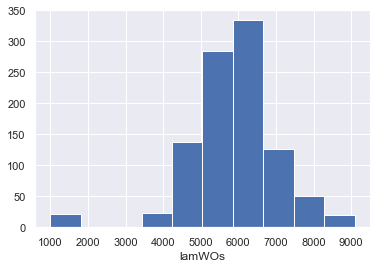

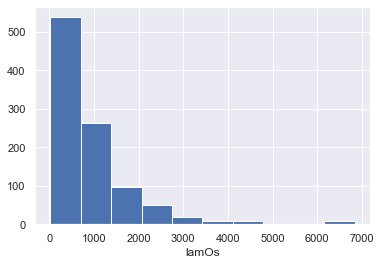

In [8]:
# Extract MCMC samples into dictionary with parameter names
samples_dict = {p.name: p.mcmc_to_array(untransform_theta=True) for p in model.params.mcmcList}

for i, k in enumerate(samples_dict.keys()):
    param_shape = samples_dict[k].shape[1]
    if param_shape >= 5:
        ncol = 5
        nrow = int(np.ceil(param_shape / ncol))
    else:
        ncol = param_shape
        nrow = 1
    plt.figure(i)
    for j in range(param_shape):
        plt.subplot(nrow, ncol, j + 1)
        plt.hist(samples_dict[k][:, j])
        plt.xlabel(k)
    plt.show()

The parameters `betaU` and `lamUz` correspond to the Gaussian process lengthscale and marginal variance,
while `lamWs`, `lamWOs`, and `lamOs` are nugget and observation noise precisions.

Most easy to interpret is `theta`, which is the posterior distribution over the $\theta$ that could have generated $y_{obs}$.
If we show the posterior distribution of `theta` on the original data plot as a rug plot, we see something interesting.

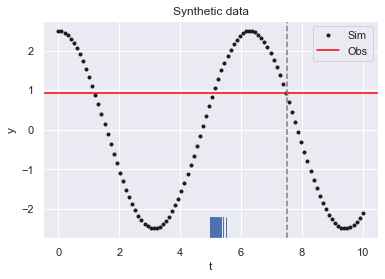

In [9]:
plt.plot(data.sim_data.t, data.sim_data.y, 'k.')
plt.axhline(data.obs_data.y, color='red')
plt.axvline(t_obs, color='grey', linestyle='dashed')
sns.rugplot(samples_dict['theta'], height=0.1)
plt.title('Synthetic data')
plt.xlabel('t')
plt.ylabel('y')
plt.legend(['Sim', 'Obs'])
plt.show()

The MCMC sampler has found a region of the input space that is consistent with the observed $y$,
but it has not found the region that actually generated the data!

If we run the sampler long enough, we would eventually expect to find a multimodal distribution for $\theta$.
As a shortcut, we will try changing the start value for `theta` to force the chain to explore other regions of input space.

In [10]:
# Explore lower end of [0, 1] region
model.params.theta.set_val(0.1)
model.do_mcmc(1000)
# Explore upper end of [0, 1] region
model.params.theta.set_val(0.9)
model.do_mcmc(1000)

MCMC sampling: 100%|██████████| 1000/1000 [00:04<00:00, 237.53it/s]


Let's see how the $\theta$ samples look with the additional iterations.

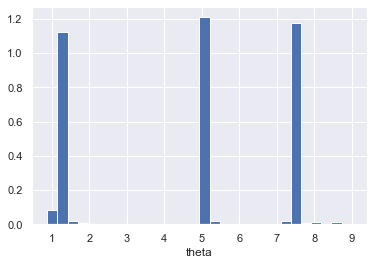

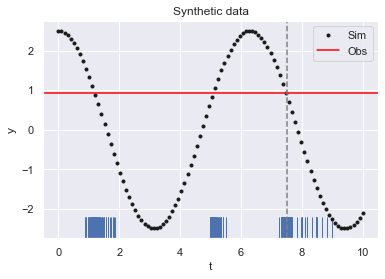

In [11]:
samples_dict = {p.name: p.mcmc_to_array(untransform_theta=True) for p in model.params.mcmcList}

plt.hist(samples_dict['theta'], bins=30, density=True)
plt.xlabel('theta')
plt.show()

plt.plot(data.sim_data.t, data.sim_data.y, 'k.')
plt.axhline(data.obs_data.y, color='red')
plt.axvline(t_obs, color='grey', linestyle='dashed')
sns.rugplot(samples_dict['theta'], height=0.1)
plt.title('Synthetic data')
plt.xlabel('t')
plt.ylabel('y')
plt.legend(['Sim', 'Obs'])
plt.show()

Now we see a trimodal distribution for `theta`, reflecting that three regions in the input space produce
observations consistent with the observed data.

### Model predictions
Finally, we will use the MCMC samples to do some predictions.
First, we get emulator predictions (which are predicting the $t$/$y$ relationship based on the simulation data).
The inputs `x_pred` and `t_pred` refer to simulation inputs where we want to predict; for now, we make these equal
to the `x` and `t` already in the model's simulation data object.
We also need to provide MCMC samples, so that the Gaussian process (GP) emulator parameters are taken from these samples.
The resulting `y` predictions are in the native space (standardization is un-done) though we can also predict in
standardized space, if desired.
We set `addResidVar = True` to get a sense of uncertainty in the GP.

We plot the predictions in blue along with the original simulation data in black:

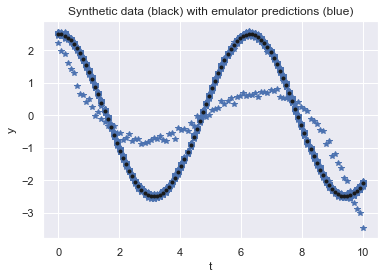

In [12]:
sampleset = np.arange(0, 3000, 60)
pred_samples = model.get_samples(sampleset=sampleset)
pred = SepiaEmulatorPrediction(samples=pred_samples, model=model, x_pred=model.data.sim_data.x_trans,
                               t_pred=model.data.sim_data.t_trans, addResidVar=True)
# Predictions are (size of sampleset, 100, 1)
y_pred = pred.get_y_native()

plt.plot(data.sim_data.t, y_pred.squeeze().T, 'b*')
plt.plot(data.sim_data.t, data.sim_data.y, 'k.')
plt.title('Synthetic data (black) with emulator predictions (blue)')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

Most of the predictions are close to the simulation data, but some are further away.
These correspond to samples in `pred_samples` and reflect particular settings of the Gaussian process
parameters for which the predictions are not very good (they appear to be oversmoothed).
Instead of showing all the predictions, we can summarize using quantiles.
We can see that a 95\% posterior interval contains the simulation data with little uncertainty.

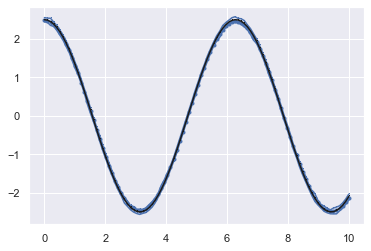

In [13]:
t_pred = pred.t_pred * 10
y_pred_q025 = np.quantile(y_pred, 0.025, axis=0).squeeze()
y_pred_mean = np.mean(y_pred, axis=0).squeeze()
y_pred_q975 = np.quantile(y_pred, 0.975, axis=0).squeeze()

plt.plot(t_pred, y_pred_mean, 'b.-')
plt.plot(t_pred, y_pred_q025, 'b,-')
plt.plot(t_pred, y_pred_q975, 'b,-')
plt.plot(data.sim_data.t, data.sim_data.y, 'k,-')
plt.show()

The emulator error is low because we are predicting at the same points where the data is observed,
and the `t` are densely spaced. 
To get a better idea of uncertainty, we can leave out chunks of the `t` space from the model, then
predict at the held out chunks.
First, we create a list of index chunks to leave out, then call `SepiaXvalEmulatorPrediction`.

In [17]:
leave_out_inds = np.array_split(np.arange(m), 5)
#leave_out_inds = [np.arange(40, 60)]
CVpred = SepiaXvalEmulatorPrediction(samples=pred_samples, model=model, x_pred=model.data.sim_data.x_trans,
                                     t_pred=model.data.sim_data.t_trans, addResidVar=True,
                                     leave_out_inds=leave_out_inds)
# Predictions are (n_samp_pred, 100, 1)
y_CVpred = CVpred.get_y_native()

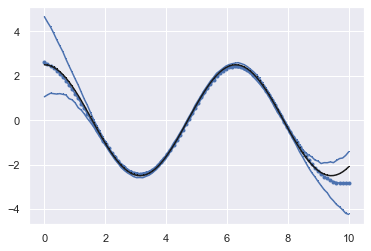

In [18]:
t_pred = CVpred.t_pred * 10
y_CVpred_q025 = np.quantile(y_CVpred, 0.025, axis=0).squeeze()
y_CVpred_mean = np.mean(y_CVpred, axis=0).squeeze()
y_CVpred_q975 = np.quantile(y_CVpred, 0.975, axis=0).squeeze()

plt.plot(t_pred, y_CVpred_mean, 'b.-')
plt.plot(t_pred, y_CVpred_q025, 'b,-')
plt.plot(t_pred, y_CVpred_q975, 'b,-')
plt.plot(data.sim_data.t, data.sim_data.y, 'k,-')
plt.show()
